In [1]:
%reset -f

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path.home()) + '/rpi-canary-eval/modules')

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from numpy import loadtxt
import tensorflow.keras.backend as K
import data_process, data_functions, data_generator, keras_model
from path import path_dict, col_seq_cc, col_seq_can

In [6]:
%config Completer.use_jedi = False

In [11]:
#### load pmpm data only
_, _, pmpm = data_process.load_data(path_dict)

In [12]:
pmpm.MYR.min(), pmpm.MYR.max()

(201701, 202107)

In [13]:
pmpm.ALLOW_AMT = pmpm.ALLOW_AMT.apply(data_process.log_)
pmpm.ALLOW_IP = pmpm.ALLOW_IP.apply(data_process.log_)
pmpm.ALLOW_ER = pmpm.ALLOW_ER.apply(data_process.log_)

In [15]:
medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0

In [16]:
def get_training_date_range(pmpm, start, end):
    date_list = pmpm.MYR.sort_values().unique().tolist()
    start_index = date_list.index(start)
    end_index = date_list.index(end)
    return date_list[start_index:end_index+1]

In [23]:
def return_stacked_training_data(pmpm, train_start, train_end, offset):
    
    training_period = get_training_date_range(pmpm.copy(), train_start, train_end)
    print(f"Training Period {training_period}")
    
    feature_start = [i for (i, _) in enumerate(training_period) if i%offset==0]
    feature_end   = [i+(offset-1) for i in feature_start]
#     label_start   = [feature_start[i] for (i,_) in enumerate(feature_start) if i>0]
#     label_end     = [feature_end[i] for (i,_) in enumerate(feature_end) if i>0]
    label_start   = feature_start
    label_end     = feature_end

#     feature_start = feature_start[:-1]
#     feature_end   = feature_end  [:-1]

    print(f"Feature Start Month Indices: {feature_start}")
    print(f"Feature End Month Indices: {feature_end}")
    print(f"Label Start Month Indices: {label_start}")
    print(f"Label End Month Indices: {label_end}")
    
    for i, val in enumerate(feature_start):
        if i==0:
            training_features, sample_weight = data_generator.generate_data(pmpm.copy(), training_period[feature_start[i]], 
                                                             training_period[feature_end[i]], features=True, 
                                                             col_seq=col_seq_can)
            training_labels, _  = data_generator.generate_data(pmpm.copy(), training_period[label_start[i]], 
                                                             training_period[label_end[i]], features=False, 
                                                             col_seq=col_seq_can)
            training_features, training_labels = data_generator.make_intersection(training_features, training_labels)
            training_features, sample_weight = data_generator.make_intersection(training_features, sample_weight)
            
            training_features = training_features.set_index('PERS_ID')
            training_labels = training_labels.set_index('PERS_ID')
            
            print(f"{training_features.shape} samples added with {training_labels.shape} labels and {sample_weight.shape} weights")

        else:
            new_training_features, new_sample_weights = data_generator.generate_data(pmpm.copy(), training_period[feature_start[i]], 
                                                             training_period[feature_end[i]], features=True, 
                                                             col_seq=col_seq_can)
            new_training_labels, _  = data_generator.generate_data(pmpm.copy(), training_period[label_start[i]], 
                                                             training_period[label_end[i]], features=False, 
                                                             col_seq=col_seq_can)
            
            new_training_features, new_training_labels = data_generator.make_intersection(new_training_features, new_training_labels)
            new_training_features, new_sample_weights = data_generator.make_intersection(new_training_features, new_sample_weights)
            
            new_training_features = new_training_features.set_index('PERS_ID')
            new_training_labels = new_training_labels.set_index('PERS_ID')

            print(f"{new_training_features.shape} samples added with {new_training_labels.shape} labels and {new_sample_weights.shape} weights")

            training_features = training_features.append(new_training_features, ignore_index=True)
            training_labels   = training_labels.append(new_training_labels, ignore_index=True)
            sample_weight     = sample_weight.append(new_sample_weights, ignore_index=True)

        print(f"Current Trainset size {training_features.shape}")
        
    return training_features, training_labels, sample_weight

In [24]:
%%time
train_data, training_labels, sample_weight = return_stacked_training_data(pmpm.copy(), 201701, 202012, offset=12)

Training Period [201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012]
Feature Start Month Indices: [0, 12, 24, 36]
Feature End Month Indices: [11, 23, 35, 47]
Label Start Month Indices: [0, 12, 24, 36]
Label End Month Indices: [11, 23, 35, 47]
(126042, 75) samples added with (126042, 75) labels and (126042, 3) weights
Current Trainset size (126042, 75)
(134558, 75) samples added with (134558, 75) labels and (134558, 3) weights
Current Trainset size (260600, 75)
(144633, 75) samples added with (144633, 75) labels and (144633, 3) weights
Current Trainset size (405233, 75)
(157330, 75) samples added with (157330, 75) labels and (157330, 3) weights
Current Trainset

In [25]:
train_data = train_data.dropna()

In [26]:
train_data

AGE_AT_MIDMONTH  LOB  MBR_GNDR  ALLOW_AMT   ALLOW_ER   ALLOW_IP  \
0            103.250000  1.0       1.0   3.974879 -14.272585 -16.118096   
1            102.666667  1.0       0.0   3.485676 -12.503763 -16.118096   
2            101.833333  1.0       0.0   5.158067 -14.185428 -14.052843   
3            101.000000  1.0       0.0   0.340103 -16.118096 -16.118096   
4            100.500000  1.0       0.0 -10.957575 -16.118096 -16.118096   
...                 ...  ...       ...        ...        ...        ...   
562558        58.000000  1.0       0.0  -2.458427 -16.118096 -16.118096   
562559        41.000000  1.0       1.0   2.275494 -16.118096 -16.118096   
562560        37.400000  1.0       0.0  -5.781028 -16.118096 -16.118096   
562561        34.000000  1.0       0.0 -16.118096 -16.118096 -16.118096   
562562        26.333333  0.0       0.0  -7.911270 -16.118096 -16.118096   

        CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  ...  \
0           0.0           0.0           0.000000     0.0  ...   
1           0.0           0.0           0.000000     0.0  ...   
2           0.0           0.0           0.000000     0.0  ...   
3           0.0           0.0           1.000000     0.0  ...   
4           0.0           0.0           0.583333     0.0  ...   
...         ...           ...                ...     ...  ...   
562558      0.0           0.0           0.000000     0.0  ...   
562559      0.0           0.0           0.000000     0.0  ...   
562560      0.0           0.0           0.000000     0.0  ...   
562561      0.0           0.0           0.000000     0.0  ...   
562562      0.0           0.0           0.000000     0.0  ...   

        CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  \
0                      0.0      0.0               0.0                     0.0   
1                      0.0      0.0               0.0                     0.0   
2                      0.0      0.0               0.0                     0.0   
3                      0.0      0.0               0.0                     0.0   
4                      0.0      0.0               0.0                     0.0   
...                    ...      ...               ...                     ...   
562558                 0.0      0.0               0.0                     0.0   
562559                 0.0      0.0               0.0                     0.0   
562560                 0.0      0.0               0.0                     0.0   
562561                 0.0      0.0               0.0                     0.0   
562562                 0.0      0.0               0.0                     0.0   

        CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  \
0                  0.0              0.0        0.0         0.0   
1                  0.0              0.0        0.0         0.0   
2                  0.0              0.0        0.0         0.0   
3                  0.0              0.0        0.0         0.0   
4                  0.0              0.0        0.0         0.0   
...                ...              ...        ...         ...   
562558             0.0              0.0        0.0         0.0   
562559             0.0              0.0        0.0         0.0   
562560             0.0              0.0        0.0         0.0   
562561             0.0              0.0        0.0         0.0   
562562             0.0              0.0        0.0         0.0   

        CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
0                      0.0          0.000000  
1                      0.0          0.000000  
2                      0.0          1.000000  
3                      0.0          0.083333  
4                      0.0          0.000000  
...                    ...               ...  
562558                 0.0          0.000000  
562559                 0.0          0.000000  
562560                 0.0          0.000000  
562561                 0.0          0.000000  
562562                 0.0          0.00000

In [27]:
training_labels = training_labels.dropna()

In [28]:
training_labels

AGE_AT_MIDMONTH  LOB  MBR_GNDR  ALLOW_AMT   ALLOW_ER   ALLOW_IP  \
0            103.250000  1.0       1.0   3.974879 -14.272585 -16.118096   
1            102.666667  1.0       0.0   3.485676 -12.503763 -16.118096   
2            101.833333  1.0       0.0   5.158067 -14.185428 -14.052843   
3            101.000000  1.0       0.0   0.340103 -16.118096 -16.118096   
4            100.500000  1.0       0.0 -10.957575 -16.118096 -16.118096   
...                 ...  ...       ...        ...        ...        ...   
562558        58.000000  1.0       0.0  -2.458427 -16.118096 -16.118096   
562559        41.000000  1.0       1.0   2.275494 -16.118096 -16.118096   
562560        37.400000  1.0       0.0  -5.781028 -16.118096 -16.118096   
562561        34.000000  1.0       0.0 -16.118096 -16.118096 -16.118096   
562562        26.333333  0.0       0.0  -7.911270 -16.118096 -16.118096   

        CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  ...  \
0           0.0           0.0           0.000000     0.0  ...   
1           0.0           0.0           0.000000     0.0  ...   
2           0.0           0.0           0.000000     0.0  ...   
3           0.0           0.0           1.000000     0.0  ...   
4           0.0           0.0           0.583333     0.0  ...   
...         ...           ...                ...     ...  ...   
562558      0.0           0.0           0.000000     0.0  ...   
562559      0.0           0.0           0.000000     0.0  ...   
562560      0.0           0.0           0.000000     0.0  ...   
562561      0.0           0.0           0.000000     0.0  ...   
562562      0.0           0.0           0.000000     0.0  ...   

        CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  \
0                      0.0      0.0               0.0                     0.0   
1                      0.0      0.0               0.0                     0.0   
2                      0.0      0.0               0.0                     0.0   
3                      0.0      0.0               0.0                     0.0   
4                      0.0      0.0               0.0                     0.0   
...                    ...      ...               ...                     ...   
562558                 0.0      0.0               0.0                     0.0   
562559                 0.0      0.0               0.0                     0.0   
562560                 0.0      0.0               0.0                     0.0   
562561                 0.0      0.0               0.0                     0.0   
562562                 0.0      0.0               0.0                     0.0   

        CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  \
0                  0.0              0.0        0.0         0.0   
1                  0.0              0.0        0.0         0.0   
2                  0.0              0.0        0.0         0.0   
3                  0.0              0.0        0.0         0.0   
4                  0.0              0.0        0.0         0.0   
...                ...              ...        ...         ...   
562558             0.0              0.0        0.0         0.0   
562559             0.0              0.0        0.0         0.0   
562560             0.0              0.0        0.0         0.0   
562561             0.0              0.0        0.0         0.0   
562562             0.0              0.0        0.0         0.0   

        CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
0                      0.0          0.000000  
1                      0.0          0.000000  
2                      0.0          1.000000  
3                      0.0          0.083333  
4                      0.0          0.000000  
...                    ...               ...  
562558                 0.0          0.000000  
562559                 0.0          0.000000  
562560                 0.0          0.000000  
562561                 0.0          0.000000  
562562                 0.0          0.00000

# Test Data

In [29]:
test_features, test_sample_weights = data_generator.generate_data(pmpm.copy(), 202001, 
                                                             202012, features=True, 
                                                             col_seq=col_seq_can)

In [30]:
test_features

PERS_ID  AGE_AT_MIDMONTH  LOB  MBR_GNDR  ALLOW_AMT   ALLOW_ER  \
0            -3       119.666667  1.0       1.0 -16.118096 -16.118096   
1       2561296        40.416667  1.0       1.0 -12.569720 -16.118096   
2       2562798       105.666667  1.0       0.0   4.577696 -14.182720   
3       2563861       103.250000  1.0       0.0   6.892239 -16.118096   
4       2563967       103.000000  1.0       0.0  -0.708103 -13.827657   
...         ...              ...  ...       ...        ...        ...   
196122  5050578        50.166667  1.0       1.0  -1.278304 -12.264115   
196123  5050907        54.000000  1.0       0.0  -5.190929 -16.118096   
196124  5051089        57.000000  1.0       1.0  -8.844840 -16.118096   
196125  5051417        40.500000  1.0       1.0  -8.746022 -16.118096   
196126  5052049        26.333333  0.0       0.0  -7.911270 -16.118096   

         ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  ...  \
0      -16.118096      0.0           0.0                0.0  ...   
1      -16.118096      0.0           0.0                0.0  ...   
2      -14.044460      0.0           0.0                1.0  ...   
3      -16.118096      0.0           0.0                0.0  ...   
4      -16.118096      0.0           0.0                1.0  ...   
...           ...      ...           ...                ...  ...   
196122 -16.118096      0.0           0.0                0.0  ...   
196123 -16.118096      0.0           0.0                0.0  ...   
196124 -16.118096      0.0           0.0                0.0  ...   
196125 -16.118096      0.0           0.0                0.0  ...   
196126 -16.118096      0.0           0.0                0.0  ...   

        CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  \
0                      0.0      0.0               0.0                     0.0   
1                      0.0      0.0               0.0                     0.0   
2                      0.0      0.0               0.0                     0.0   
3                      0.0      0.0               0.0                     0.0   
4                      0.0      0.0               0.0                     0.0   
...                    ...      ...               ...                     ...   
196122                 0.0      0.0               0.0                     0.0   
196123                 0.0      0.0               0.0                     0.0   
196124                 0.0      0.0               0.0                     0.0   
196125                 0.0      0.0               0.0                     0.0   
196126                 0.0      0.0               0.0                     0.0   

        CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  \
0                  0.0              0.0        0.0         0.0   
1                  0.0              0.0        0.0         0.0   
2                  0.0              0.0        0.0         0.0   
3                  0.0              0.0        0.0         0.0   
4                  0.0              0.0        0.0         0.0   
...                ...              ...        ...         ...   
196122             0.0              0.0        0.0         0.0   
196123             0.0              0.0        0.0         0.0   
196124             0.0              0.0        0.0         0.0   
196125             0.0              0.0        0.0         0.0   
196126             0.0              0.0        0.0         0.0   

        CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  
0                      0.0               0.0  
1                      0.0               0.0  
2                      0.0               0.0  
3                      0.0               0.0  
4                      0.0               0.0  
...                    ...               ...  
196122                 0.0               0.0  
196123                 0.0               0.0  
196124                 0.0               0.0  
196125                 0.0               0.0  
196126                 0.0     

In [31]:
test_labels, _ = data_generator.generate_data(pmpm.copy(), 202101, 
                                                             202107, features=False, 
                                                             col_seq=col_seq_can)

In [32]:
test_labels.shape

(184385, 76)

In [34]:
test_features, test_labels = data_generator.make_intersection(test_features, test_labels)

## Sample weight calculation

In [35]:
sample_weight

PERS_ID   0    weight
0       2562628  12  1.000000
1       2562798  12  1.000000
2       2563150  12  1.000000
3       2563500  12  1.000000
4       2563709  12  1.000000
...         ...  ..       ...
562558  5040176  10  0.833333
562559  5040356  10  0.833333
562560  5040970  10  0.833333
562561  5041568  10  0.833333
562562  5052049  12  1.000000

[562563 rows x 3 columns]

In [33]:
sample_weight.weight.values

array([1.        , 1.        , 1.        , ..., 0.83333333, 0.58333333,
       1.        ])

## Training

In [36]:
baseline_model = keras_model.make_model_6(input_shape=train_data.shape[1])
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

In [37]:
%%time
num_epochs = 20

#use this when multi-dim vectored output head
baseline_history = baseline_model.fit(train_data.values, training_labels.values, epochs=num_epochs, validation_split=0.1, 
                                      batch_size=128, verbose=1, sample_weight=sample_weight.weight.values)

Train on 506306 samples, validate on 56257 samples
Epoch 1/20
506306/506306 [==============================] - 11s 22us/step - loss: 6.4499 - val_loss: 1.7732
Epoch 2/20
506306/506306 [==============================] - 11s 22us/step - loss: 3.1011 - val_loss: 1.6782
Epoch 3/20
506306/506306 [==============================] - 11s 21us/step - loss: 2.8043 - val_loss: 1.5261
Epoch 4/20
506306/506306 [==============================] - 11s 21us/step - loss: 2.5968 - val_loss: 1.4826
Epoch 5/20
506306/506306 [==============================] - 11s 21us/step - loss: 2.4741 - val_loss: 1.5621
Epoch 6/20
506306/506306 [==============================] - 11s 21us/step - loss: 2.3992 - val_loss: 1.4696
Epoch 7/20
506306/506306 [==============================] - 11s 21us/step - loss: 2.3440 - val_loss: 1.4361
Epoch 8/20
506306/506306 [==============================] - 11s 21us/step - loss: 2.2891 - val_loss: 1.5093
Epoch 9/20
506306/506306 [==============================] - 11s 21us/step - loss: 2.2

In [38]:
baseline_history.history.keys()

dict_keys(['val_loss', 'loss'])

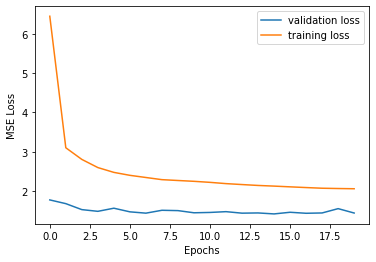

In [39]:
import matplotlib.pyplot as plt
plt.plot(baseline_history.history.get('val_loss'), label="validation loss")
plt.plot(baseline_history.history.get('loss'), label="training loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel('MSE Loss')
plt.savefig("Loss.jpg")
plt.show()

# Prediction Performance on Test Data

In [40]:
test_predicted_labels = baseline_model.predict(test_features.set_index("PERS_ID").values)

In [41]:
test_actual_labels = test_labels.set_index("PERS_ID").values

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [43]:
mean_absolute_error(test_actual_labels, test_predicted_labels)

0.23319855083024943

In [44]:
mean_squared_error(test_actual_labels, test_predicted_labels, squared=True)

0.9817653127853676

In [45]:
#RMSE
mean_squared_error(test_actual_labels, test_predicted_labels, squared=False)

0.3638048581570528

# Save

In [46]:
latent_model = tf.keras.Model(baseline_model.input, baseline_model.get_layer("representation").output)

In [47]:
#freeze all the layers in both models
for layer in baseline_model.layers:
    layer.trainable=False
for layer in latent_model.layers:
    layer.trainable=False

In [48]:
## save the models
baseline_model.save('../temp/TF_Full_Model_m6_Canary_stacked_AE_logfixed')
latent_model.save('../temp/TF_Latent_Model_m6_Canary_stacked_AE_logfixed')

In [50]:
#save in S3
import boto3
s3 = boto3.client('s3')
bucket = 'cdphp-s3-us-e-p-pond'
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Latent_Model_m6_Canary_stacked_AE_logfixed',
                bucket, 
                'rpi/nneehal/MODELS/TF_Latent_Model_m6_Canary_stacked_AE_logfixed',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})
s3.upload_file( str(Path.home()) + '/rpi-canary-eval/temp/TF_Full_Model_m6_Canary_stacked_AE_logfixed',
                bucket, 
                'rpi/nneehal/MODELS/TF_Full_Model_m6_Canary_stacked_AE_logfixed',
                ExtraArgs = {'ACL':"bucket-owner-full-control", 'ServerSideEncryption':'AES256'})